# DATA SCIENCE - Bank Marketing (Campaign)

## Problem statement

ABC Bank wants to sell it's term deposit product to customers and before launching the product they want to develop a model which help them in understanding whether a particular customer will buy their product or not (based on customer's past interaction with bank or other Financial Institution).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
pd.set_option('display.max_columns', 500)
import missingno as msno
from datetime import datetime, timedelta
from matplotlib import rcParams
#import xgboost

%matplotlib inline
sns.set()
plt.rc('xtick', labelsize=10)     
plt.rc('ytick', labelsize=10)




In [2]:
path = "/Users/vicentesolorzano/Desktop/DATA_GLACIER/FINAL/data/bank-additional-full.csv"

df = pd.read_csv(path,sep=";")
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
print("Number of rows: ",df.shape[0]," - ","Number of columns: ",df.shape[1])

Number of rows:  41188  -  Number of columns:  21


Columns: 

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Columns types:

In [5]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

At first sight, we don´t have any nulls in the dataset:

In [6]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## DATA UNDERSTANDING

The data is related with direct marketing campaigns of a Portuguese banking institution. They provided us with certain data of more than 41.000 clients. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

# I) FEATURES

### Data related with clients : 

1) age (numeric)

2) job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3) marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4) education (categorical): 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5) default: has credit in default? (categorical: 'no','yes','unknown')

6) housing: has housing loan? (categorical: 'no','yes','unknown')

7) loan: has personal loan? (categorical: 'no','yes','unknown')

### Data related with the last contact :

8) contact: contact communication type (categorical: 'cellular','telephone') 

9) month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10) day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11) duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Data related with the campaing :

12) campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13) pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14) previous: number of contacts performed before this campaign and for this client (numeric)

15) poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Data related with social and economic context attributes:

16) emp.var.rate: employment variation rate - quarterly indicator (numeric)

17) cons.price.idx: consumer price index - monthly indicator (numeric) 

18) cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

19) euribor3m: euribor 3 month rate - daily indicator (numeric)

20) nr.employed: number of employees - quarterly indicator (numeric)

### Target :

21) y - has the client subscribed a term deposit? (binary: 'yes','no')

In [7]:
#Separate features into different features to work easily. 
#They will have the features for each topic and the target.

client_columns = ['age','job', 'marital', 'education', 'default', 'housing', 'loan',"y"]
contact_columns = ['contact', 'month', 'day_of_week', 'duration',"y"]
campaign_columns = ['campaign', 'pdays','previous', 'poutcome',"y"]
socioeconomic_columns = ['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed',"y"]

client_df = df[client_columns]
contact_df = df[contact_columns]
campaign_df = df[campaign_columns]
socioeconomic_df = df[socioeconomic_columns]


# II) EDA (Exploratory Data Analysis)

## 1) CLIENTS

### Demographic analysis


In [8]:
client_df.head(2)

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,no
1,57,services,married,high.school,unknown,no,no,no


### Marital state

In [9]:
client_df.groupby("marital")["age"].count()

marital
divorced     4612
married     24928
single      11568
unknown        80
Name: age, dtype: int64

In [10]:
marital=(client_df.groupby("marital")["age"].count())/client_df.marital.count()*100
#marital.sum()

print("Marital state of customers (%): ")

marital

Marital state of customers (%): 


marital
divorced    11.197436
married     60.522482
single      28.085850
unknown      0.194231
Name: age, dtype: float64

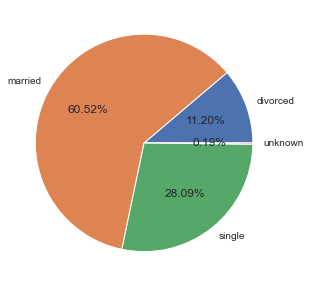

In [11]:
#Marital state

labels= ["divorced","married","single","unknown"]

fig = plt.figure(figsize=(10,5)); ax = plt.axes()

ax.pie(marital, labels = labels ,autopct='%1.2f%%')
plt.show()




### Job

In [12]:
client_df.groupby("job")["age"].count()

job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: age, dtype: int64

In [13]:
job=(client_df.groupby("job")["age"].count())/client_df.age.count()*100
#marital.sum()

print("Customers job (%): ")

job.sort_values(ascending=False)

Customers job (%): 


job
admin.           25.303486
blue-collar      22.467709
technician       16.371273
services          9.636302
management        7.099155
retired           4.175974
entrepreneur      3.535010
self-employed     3.450034
housemaid         2.573565
unemployed        2.461882
student           2.124405
unknown           0.801204
Name: age, dtype: float64

The majority of our customers are in 3 jobs: administration, blue collar or technician.

Text(0.5, 0, 'Jobs')

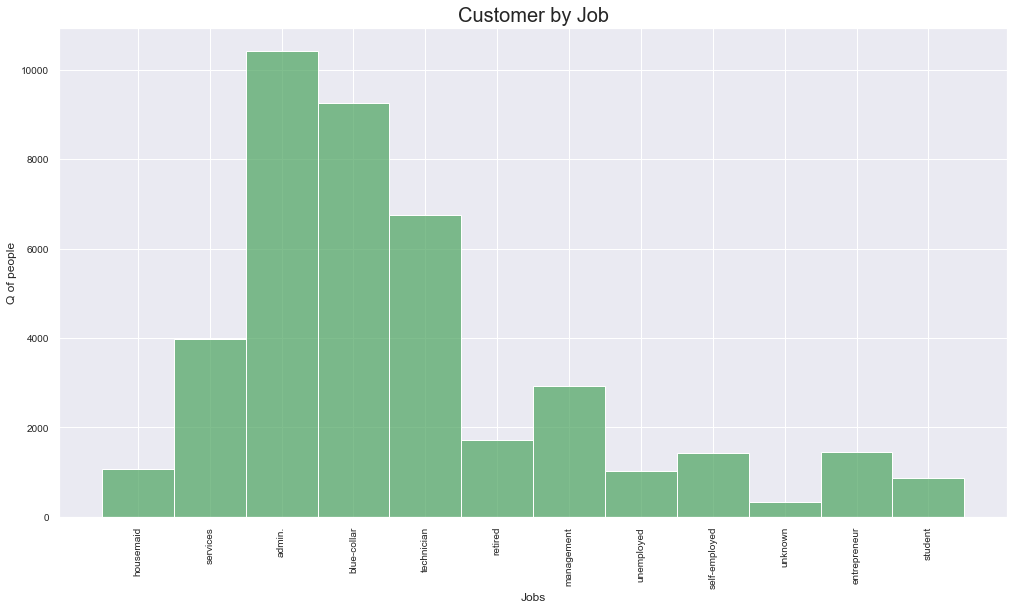

In [14]:

plt.figure(figsize=(17,9))



ax=sns.histplot(data=client_df.job,bins=40, color= 'g')
plt.setp( ax.get_xticklabels(),rotation=90)
plt.title('Customer by Job', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Jobs')

### Age range

In [15]:
ranges=[0,30,40,50,60,100]
labels=["30 and under","31-40","41-50","51-60","over 60"]

client_df["age_range"]=pd.cut(client_df.age,bins= ranges,labels=labels)


In [16]:
customer_age_range=(client_df.groupby("age_range")["age"].count())/client_df.age.count()*100
#marital.sum()

print("Customers by age (%): ")

customer_age_range
#job.sort_values(ascending=False)

Customers by age (%): 


age_range
30 and under    17.925124
31-40           39.781004
41-50           24.861610
51-60           15.222880
over 60          2.209381
Name: age, dtype: float64

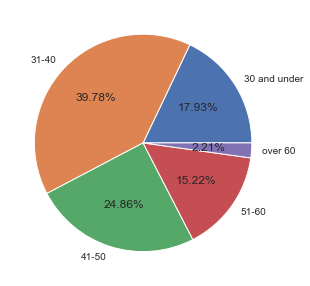

In [17]:
#age range

labels=["30 and under","31-40","41-50","51-60","over 60"]
fig = plt.figure(figsize=(10,5)); ax = plt.axes()

ax.pie(customer_age_range, labels = labels ,autopct='%1.2f%%')
plt.show()

31-40 and 41-50 seems to be our age segments with most customers. There are 64.6% of the customers

### Education

In [18]:
client_df.groupby("education")["age"].count()

education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
Name: age, dtype: int64

In [19]:
education_cust=(client_df.groupby("education")["age"].count())/client_df.age.count()*100
#marital.sum()

print("Customers education (%): ")

education_cust=education_cust.sort_values(ascending=False)
education_cust

Customers education (%): 


education
university.degree      29.542585
high.school            23.101389
basic.9y               14.676605
professional.course    12.729436
basic.4y               10.138875
basic.6y                5.564728
unknown                 4.202680
illiterate              0.043702
Name: age, dtype: float64

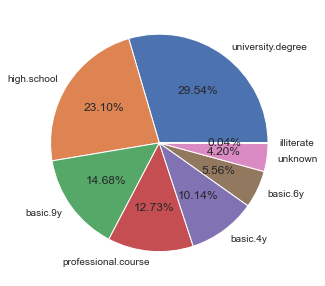

In [20]:
#education

labels=list(education_cust.index)
fig = plt.figure(figsize=(10,5)); ax = plt.axes()

ax.pie(education_cust ,labels=labels,autopct='%1.2f%%')
plt.show()

More than the 65% of the customers have at least a high school degree. More than 35% have a professional course or university degree.

### Default, housing & loan

Text(0.5, 0, 'Personal loan')

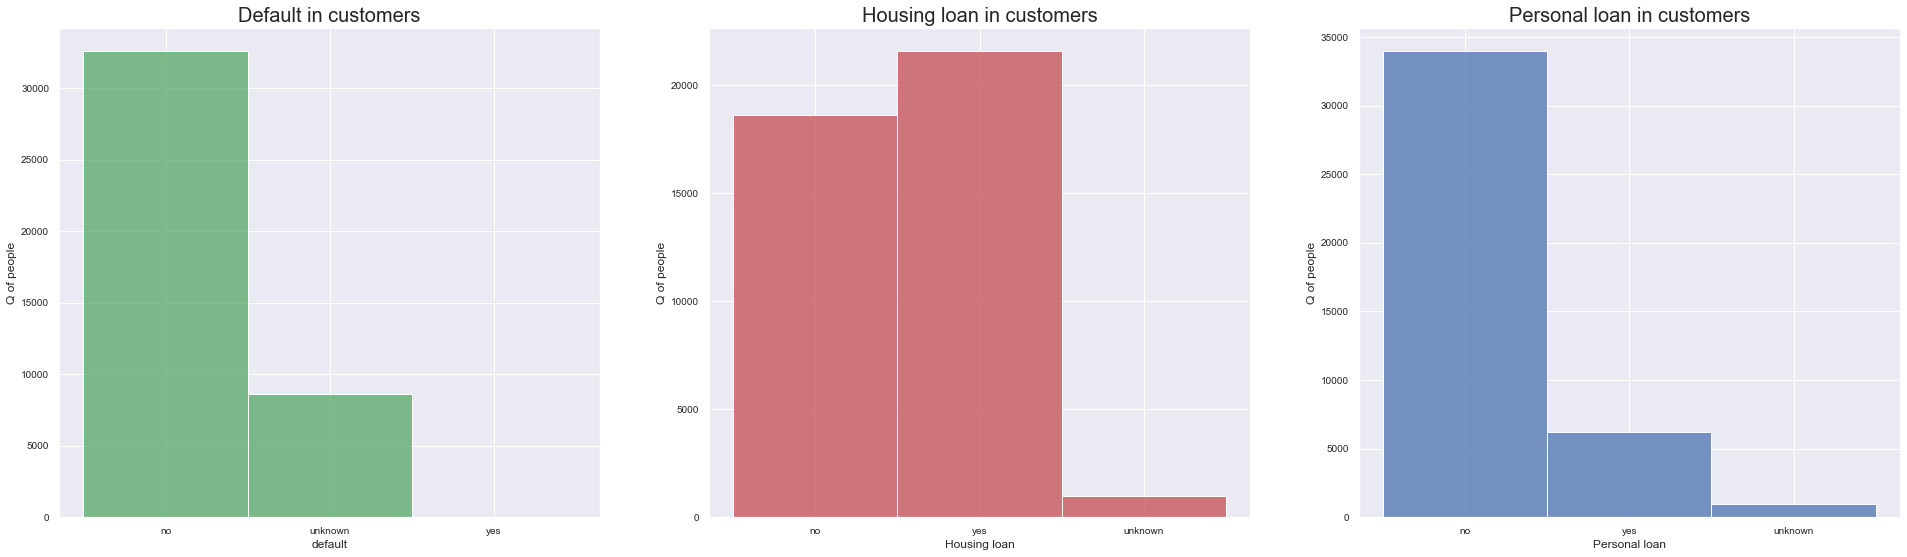

In [21]:
plt.figure(figsize=(33,9))

plt.subplot(1,3,1)

ax=sns.histplot(data=client_df.default,bins=40, color= 'g')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Default in customers', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('default')

plt.subplot(1,3,2)

ax=sns.histplot(data=client_df.housing,bins=40, color= 'r')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Housing loan in customers', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Housing loan')

plt.subplot(1,3,3)

ax=sns.histplot(data=client_df.loan,bins=40, color= 'b')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Personal loan in customers', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Personal loan')

In [22]:
default_cust=client_df.groupby("default")["age"].count()
default_cust

default
no         32588
unknown     8597
yes            3
Name: age, dtype: int64

In [23]:
default_cust/client_df.age.count()*100

default
no         79.120132
unknown    20.872584
yes         0.007284
Name: age, dtype: float64

Seems to be a lack of customers in default, just 3, but consider that unknown have to be taken as null values. Unknown are more than 20% of the customers.

## 2)  Last Contact 

Little analysis of the data about the last contact.

In [24]:
contact=contact_df.groupby("contact")["contact"].count()

contact_per=contact/contact_df.contact.count()*100

contact_per

contact
cellular     63.474798
telephone    36.525202
Name: contact, dtype: float64

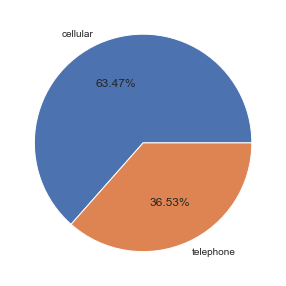

In [25]:


labels=list(contact.index)
fig = plt.figure(figsize=(10,5)); ax = plt.axes()

ax.pie(contact_per ,labels=labels,autopct='%1.2f%%')
plt.show()

In [26]:
contact_month=contact_df.groupby("month")["contact"].count().sort_values(ascending=False)
contact_month_df=pd.DataFrame(contact_month)


contact_month_df.head(5)


,contact
month,
may,13769
jul,7174
aug,6178
jun,5318
nov,4101


5 top contact months were may , july, august, june and november.

Text(0.5, 0, 'Duration of the call')

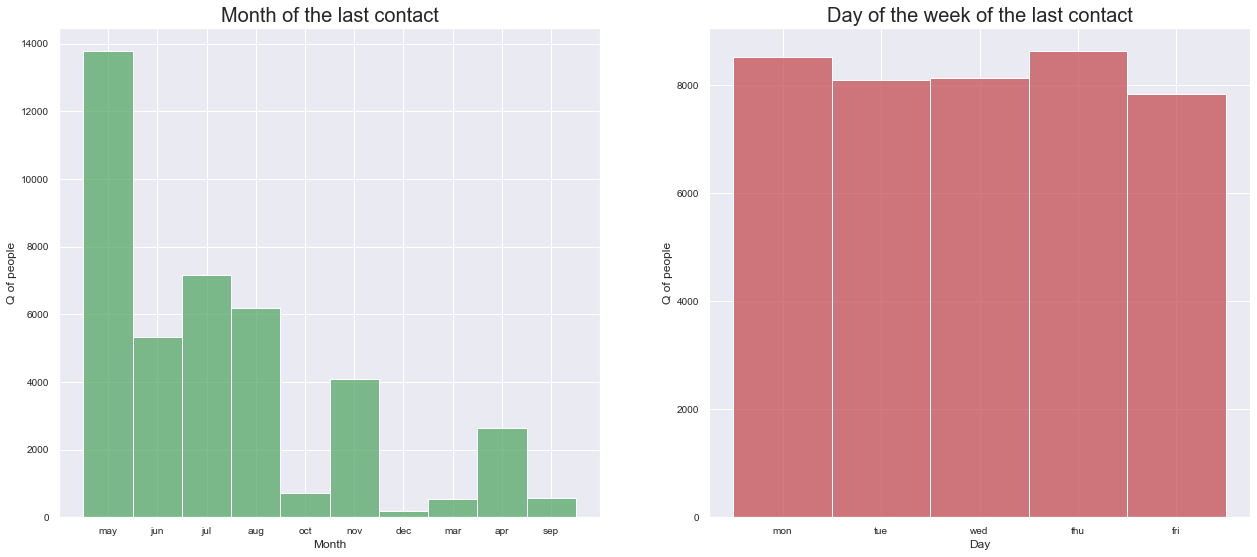

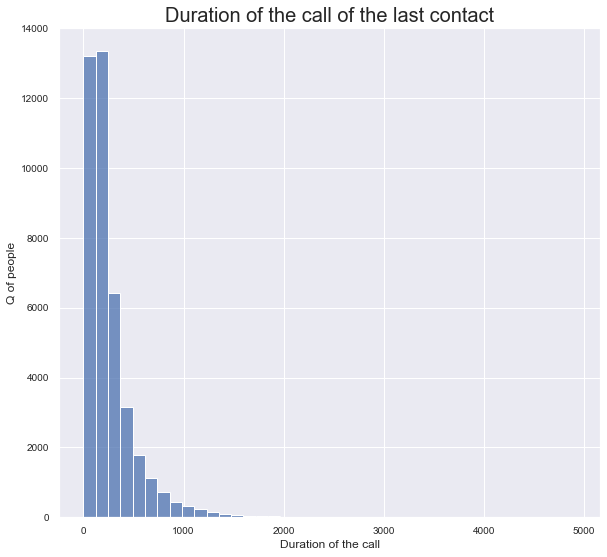

In [27]:
plt.figure(figsize=(33,9))

plt.subplot(1,3,1)

ax=sns.histplot(data=contact_df.month,bins=40, color= 'g')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Month of the last contact', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Month')

plt.subplot(1,3,2)

ax=sns.histplot(data=contact_df.day_of_week,bins=40, color= 'r')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Day of the week of the last contact', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Day')

plt.figure(figsize=(33,9))

plt.subplot(1,3,3)

ax=sns.histplot(data=contact_df.duration,bins=40, color= 'b')
plt.setp( ax.get_xticklabels(),rotation=0)
plt.title('Duration of the call of the last contact', fontsize=20)
plt.ylabel('Q of people')
plt.xlabel('Duration of the call')



In [28]:
contact_df.duration[contact_df.duration=="unknown"]

Series([], Name: duration, dtype: int64)

Contact are almost the same by the different days of the week. The most

In [29]:
contact_df.duration.unique()

array([ 261,  149,  226, ..., 1246, 1556, 1868])

In [30]:
ranges=[-1,200,400,600,800,1000,5000]
labels=["0-200","201-400","401-600","601-800","801-1000","over 1000"]

contact_df["duration_range"]=pd.cut(contact_df.duration,bins= ranges,labels=labels)



In [31]:
contact_duration_range=contact_df.groupby("duration_range")["contact"].count()
contact_duration_range

duration_range
0-200        22760
201-400      11264
401-600       3700
601-800       1707
801-1000       801
over 1000      956
Name: contact, dtype: int64

As we know, this attribute highly affects the output target. So it is a nice a anlysis to understand how it is related with "y" rate, but it is a little useless. We won´t have this information if we want to predict the future acceptance by the client.

## 3) Campaing 

In [32]:
poutcome_gb=campaign_df.groupby("poutcome")["campaign"].count()

poutcome_gb_per=poutcome_gb/campaign_df.campaign.count()*100

Outcome of the previous marketing campaign: 

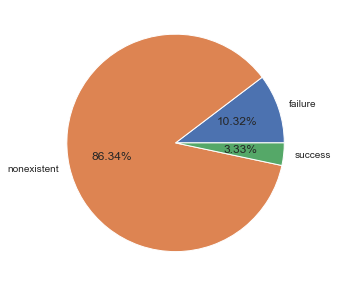

In [33]:
labels=list(poutcome_gb_per.index)
fig = plt.figure(figsize=(10,5)); ax = plt.axes()

ax.pie(poutcome_gb_per ,labels=labels,autopct='%1.2f%%')
plt.show()


Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [34]:
ranges=[-1,3,6,9,12,100]
labels=["0-3","4-6","7-9","10-12","More than 12"]

campaign_df["campaign_range"]=pd.cut(campaign_df.campaign,bins= ranges,labels=labels)



In [35]:
campaign_range_df=campaign_df.groupby("campaign_range")["campaign"].count()

campaign_range_df_per=campaign_range_df/(campaign_df.campaign.count())*100

campaign_range_df_per

campaign_range
0-3             81.463047
4-6             12.695445
7-9              3.185394
10-12            1.279499
More than 12     1.376615
Name: campaign, dtype: float64

In [22]:

#pdays
#numeric; 999 means client was not previously contacted)
#poutcome
#nonexistent = there were not previous campaign.

"pdays": Number of days that passed by after the client was last contacted from a previous campaign: (numeric; 999 means client was not previously contacted)

In [36]:
ranges=[-1,5,10,15,20,25,30,1000]
labels=["0-5","6-10","11-15","16-20","21-25","26-30","No previous contacted"]

campaign_df["pdays_range"]=pd.cut(campaign_df.pdays,bins= ranges,labels=labels)


In [37]:
pdays_range_df=campaign_df.groupby("pdays_range")["campaign"].count()

pdays_range_df_per=pdays_range_df/(campaign_df.campaign.count())*100

pdays_range_df_per


pdays_range
0-5                       1.711664
6-10                      1.471302
11-15                     0.403030
16-20                     0.072837
21-25                     0.014567
26-30                     0.004856
No previous contacted    96.321744
Name: campaign, dtype: float64

Most of clients were no contacted before (96%).

Previous: number of contacts performed before this campaign and for this client (numeric)

In [38]:
campaign_df.groupby("previous")["campaign"].count()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: campaign, dtype: int64

## 4) BIVARIAL ANALYSIS -  Features and target

### Age range and target

Text(0.5, 1.0, 'Agewise Distribution')

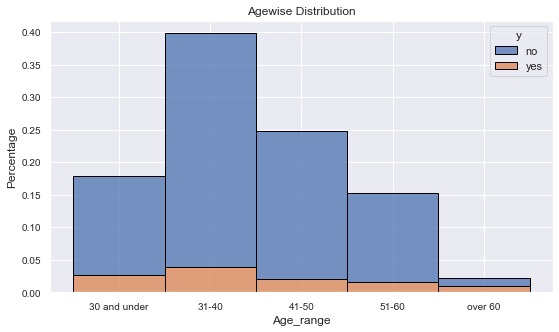

In [49]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.histplot(data=client_df, x='age_range', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.xlabel("Age_range") 
plt.ylabel("Percentage")
plt.title("Agewise Distribution")

In [40]:
cross_tab_age = pd.crosstab(client_df['y'],client_df["age_range"]).apply(lambda x: x/x.sum() * 100)
cross_tab_age = cross_tab_age.transpose()
cross_tab_age

y,no,yes
age_range,,
30 and under,84.775836,15.224164
31-40,90.253280,9.746720
41-50,91.826172,8.173828
51-60,89.346093,10.653907
over 60,54.505495,45.494505


People over 60 is the range with higher acceptance range of the term deposit.

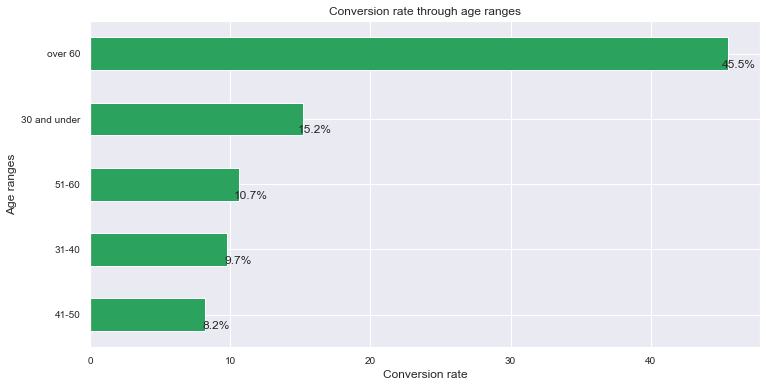

In [42]:
age_conversion = cross_tab_age['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through age ranges')
plt.xlabel('Conversion rate')
plt.ylabel('Age ranges')

# Por estas funciones prefiero ggplot
for rec, label in zip(age_conversion.patches,
                      cross_tab_age["yes"].sort_values(ascending = True).round(1).astype(str)):
    age_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

### Job, Marital, Education and target

In [23]:
client_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y',
       'age_range'],
      dtype='object')

Text(0.5, 1.0, 'Education Distribution')

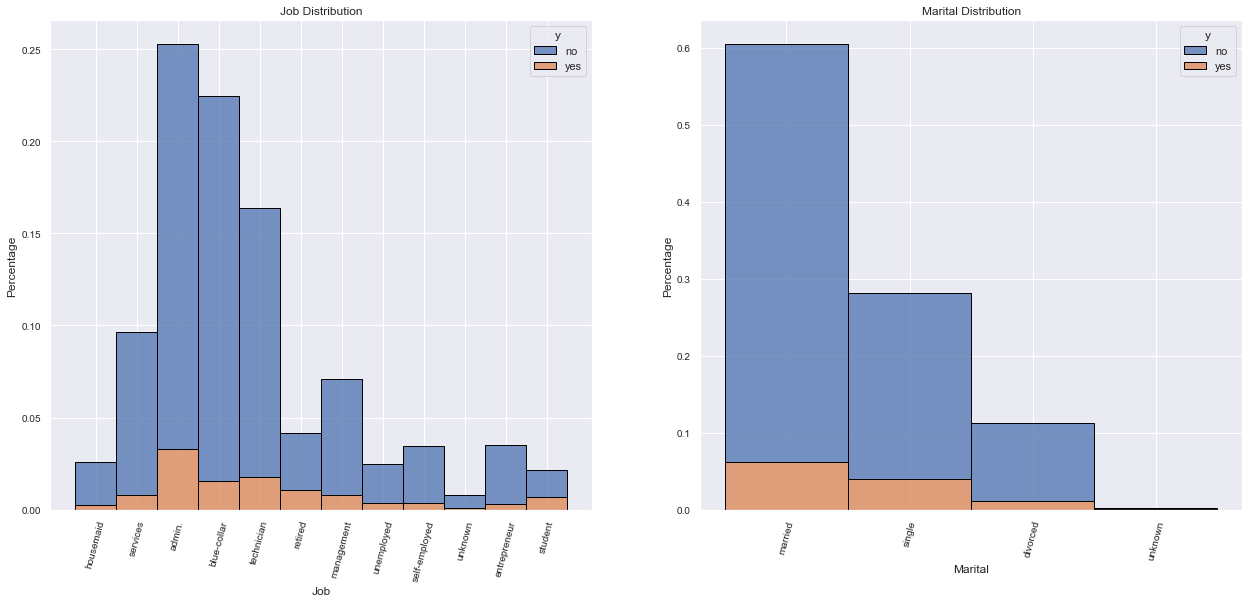

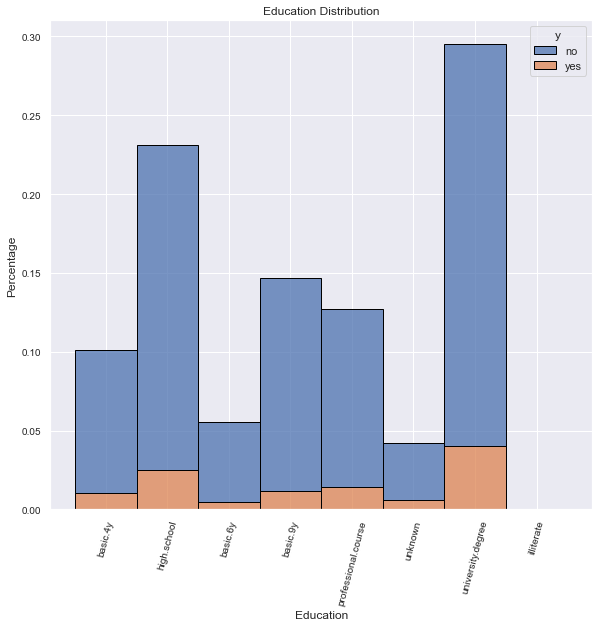

In [42]:
plt.figure(figsize=(33,9))

plt.subplot(1,3,1)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=client_df, x='job', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Job") 
plt.ylabel("Percentage")
plt.title("Job Distribution")

plt.subplot(1,3,2)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=client_df, x='marital', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Marital") 
plt.ylabel("Percentage")
plt.title("Marital Distribution")

plt.figure(figsize=(33,9))

plt.subplot(1,3,3)

#fig, ax = plt.subplots(figsize = (9, 5))
#plt.setp( ax.get_xticklabels(),rotation=90)
ax = sns.histplot(data=client_df, x='education', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Education") 
plt.ylabel("Percentage")
plt.title("Education Distribution")



In [43]:
client_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y',
       'age_range'],
      dtype='object')

In [44]:
cross_tab_job = pd.crosstab(client_df['y'],client_df["job"]).apply(lambda x: x/x.sum() * 100)
cross_tab_job = cross_tab_job.transpose()
print("Jobs and target: ")
print(cross_tab_job)

cross_tab_marital = pd.crosstab(client_df['y'],client_df["marital"]).apply(lambda x: x/x.sum() * 100)
cross_tab_marital = cross_tab_marital.transpose()
print("Marital and target: ")
print(cross_tab_marital)

cross_tab_education = pd.crosstab(client_df['y'],client_df["education"]).apply(lambda x: x/x.sum() * 100)
cross_tab_education = cross_tab_education.transpose()
print("Education and target: ")
print(cross_tab_education)

Jobs and target: 
y                     no        yes
job                                
admin.         87.027442  12.972558
blue-collar    93.105684   6.894316
entrepreneur   91.483516   8.516484
housemaid      90.000000  10.000000
management     88.782490  11.217510
retired        74.767442  25.232558
self-employed  89.514426  10.485574
services       91.861930   8.138070
student        68.571429  31.428571
technician     89.173958  10.826042
unemployed     85.798817  14.201183
unknown        88.787879  11.212121
Marital and target: 
y                no        yes
marital                       
divorced  89.679098  10.320902
married   89.842747  10.157253
single    85.995851  14.004149
unknown   85.000000  15.000000
Education and target: 
y                           no        yes
education                                
basic.4y             89.750958  10.249042
basic.6y             91.797557   8.202443
basic.9y             92.175352   7.824648
high.school          89.164477  10.835

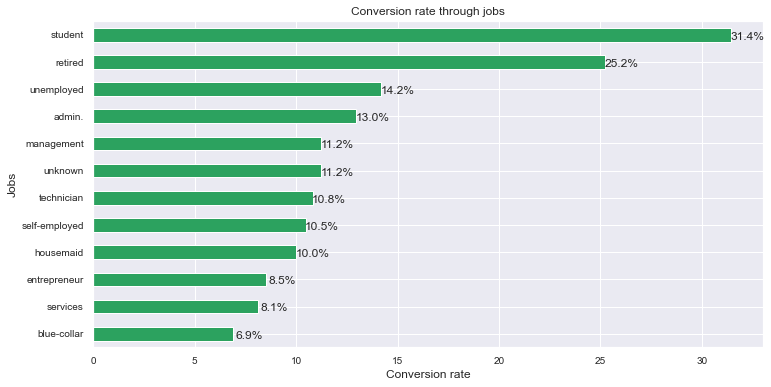

In [48]:
job_conversion = cross_tab_job['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through jobs')
plt.xlabel('Conversion rate')
plt.ylabel('Jobs')

# Por estas funciones prefiero ggplot
for rec, label in zip(job_conversion.patches,
                      cross_tab_job["yes"].sort_values(ascending = True).round(1).astype(str)):
    job_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Retired and student are the jobs that have the highest acceptance rate.

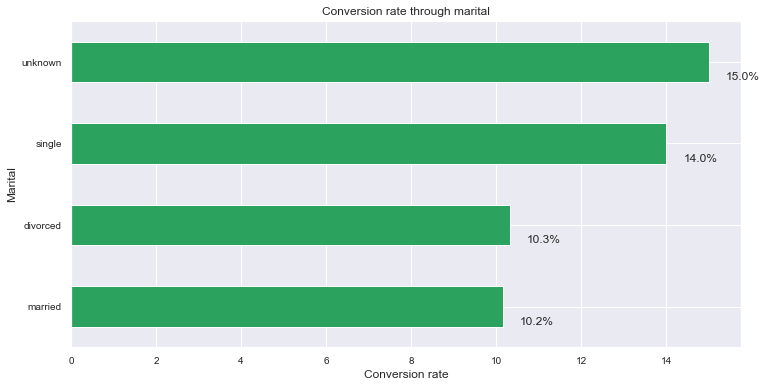

In [49]:
marital_conversion = cross_tab_marital['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through marital')
plt.xlabel('Conversion rate')
plt.ylabel('Marital')

# Por estas funciones prefiero ggplot
for rec, label in zip(marital_conversion.patches,
                      cross_tab_marital["yes"].sort_values(ascending = True).round(1).astype(str)):
    marital_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Single clients are the marital stage with highest acceptance rate.

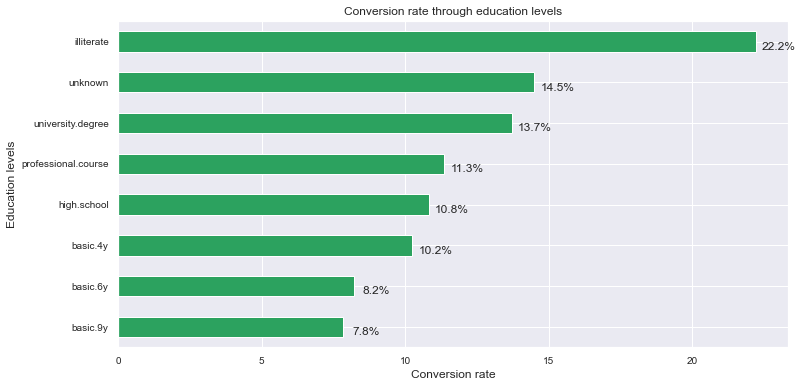

In [50]:
education_conversion = cross_tab_education['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through education levels')
plt.xlabel('Conversion rate')
plt.ylabel('Education levels')

# Por estas funciones prefiero ggplot
for rec, label in zip(education_conversion.patches,
                      cross_tab_education["yes"].sort_values(ascending = True).round(1).astype(str)):
    education_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Illiterate people are by far the clients who are buying the term deposit.

### Default, Housing Loan, Personal Loan and Target

Text(0.5, 1.0, 'Personal loan')

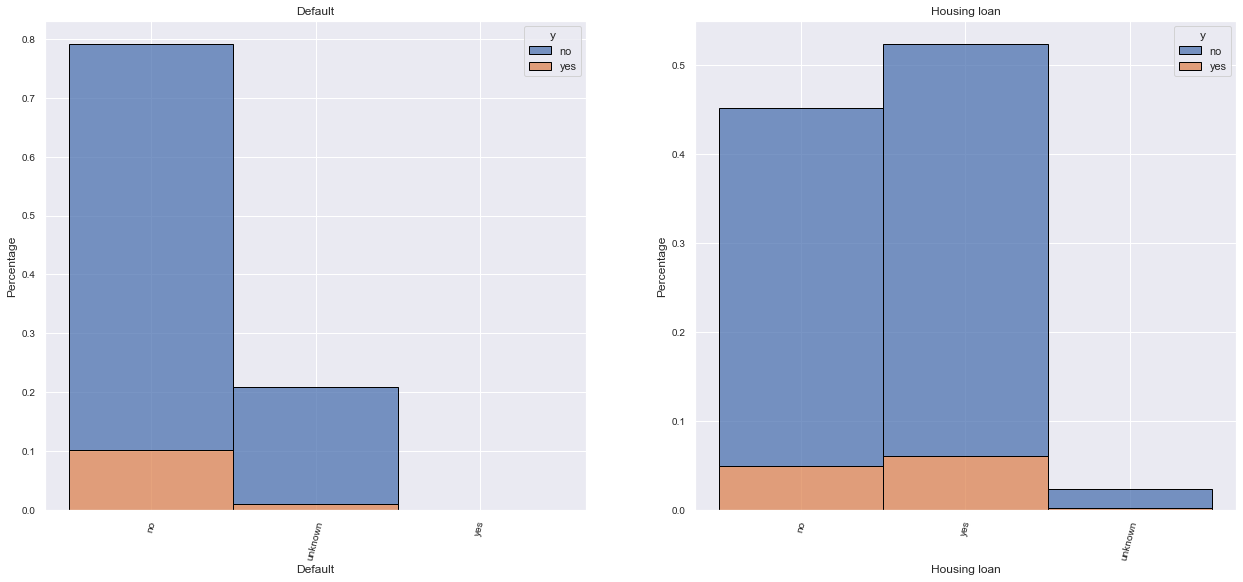

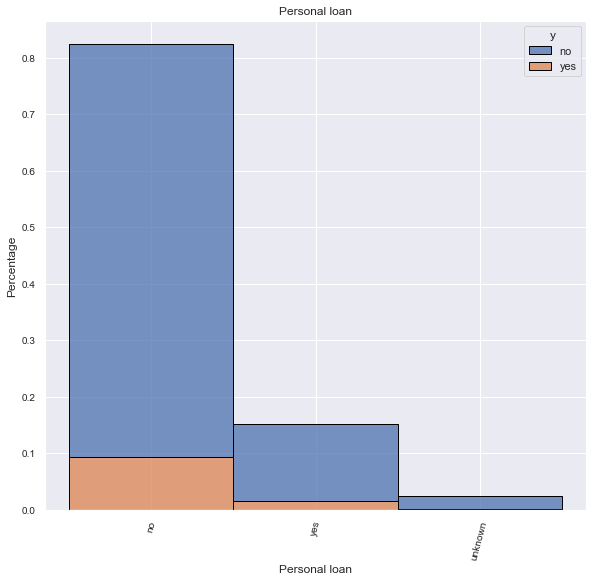

In [44]:
plt.figure(figsize=(33,9))

plt.subplot(1,3,1)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=client_df, x='default', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Default") 
plt.ylabel("Percentage")
plt.title("Default")

plt.subplot(1,3,2)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=client_df, x='housing', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Housing loan") 
plt.ylabel("Percentage")
plt.title("Housing loan")

plt.figure(figsize=(33,9))

plt.subplot(1,3,3)

#fig, ax = plt.subplots(figsize = (9, 5))
#plt.setp( ax.get_xticklabels(),rotation=90)
ax = sns.histplot(data=client_df, x='loan', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Personal loan") 
plt.ylabel("Percentage")
plt.title("Personal loan")



In [51]:
cross_tab_default = pd.crosstab(client_df['y'],client_df["default"]).apply(lambda x: x/x.sum() * 100)
cross_tab_default = cross_tab_default.transpose()
print("Default and target: ")
print(cross_tab_default)

cross_tab_housing = pd.crosstab(client_df['y'],client_df["housing"]).apply(lambda x: x/x.sum() * 100)
cross_tab_housing = cross_tab_housing.transpose()
print("Housing and target: ")
print(cross_tab_housing)

cross_tab_loan = pd.crosstab(client_df['y'],client_df["loan"]).apply(lambda x: x/x.sum() * 100)
cross_tab_loan = cross_tab_loan.transpose()
print("Loan and target: ")
print(cross_tab_loan)

Default and target: 
y                no        yes
default                       
no        87.121026  12.878974
unknown   94.847040   5.152960
yes      100.000000   0.000000
Housing and target: 
y               no        yes
housing                      
no       89.120395  10.879605
unknown  89.191919  10.808081
yes      88.380608  11.619392
Loan and target: 
y               no        yes
loan                         
no       88.659794  11.340206
unknown  89.191919  10.808081
yes      89.068502  10.931498


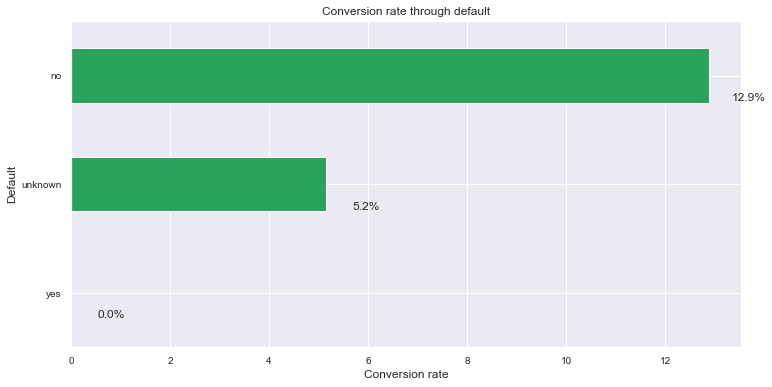

In [53]:
default_conversion = cross_tab_default['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through default')
plt.xlabel('Conversion rate')
plt.ylabel('Default')

# Por estas funciones prefiero ggplot
for rec, label in zip(default_conversion.patches,
                      cross_tab_default["yes"].sort_values(ascending = True).round(1).astype(str)):
    default_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

We don't have reliable information to conclude. Unknown will be consider as nulls for the case and there is no clients who are in default and accepted the term deposit (according to the dataset).

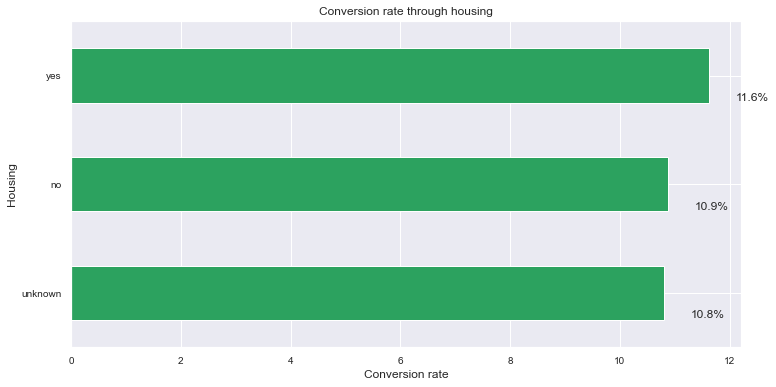

In [54]:
housing_conversion = cross_tab_housing['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through housing')
plt.xlabel('Conversion rate')
plt.ylabel('Housing')

# Por estas funciones prefiero ggplot
for rec, label in zip(housing_conversion.patches,
                      cross_tab_housing["yes"].sort_values(ascending = True).round(1).astype(str)):
    housing_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

At first sight, there is no relation between having personal loan and accepting the term deposit. The acceptance rate is similar.

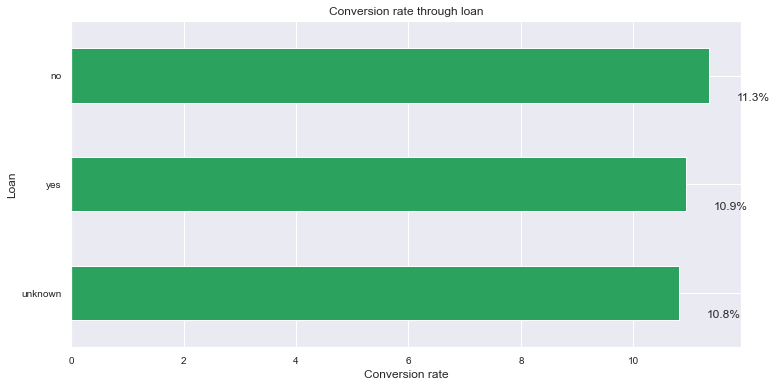

In [55]:
loan_conversion = cross_tab_loan['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate through loan')
plt.xlabel('Conversion rate')
plt.ylabel('Loan')

# Por estas funciones prefiero ggplot
for rec, label in zip(loan_conversion.patches,
                      cross_tab_loan["yes"].sort_values(ascending = True).round(1).astype(str)):
    loan_conversion.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

At first sight, there is no relation between having personal loan and accepting the term deposit. The acceptance rate is similar.

### Last Contact and target

In [121]:
contact_df.columns

Index(['contact', 'month', 'day_of_week', 'duration', 'y', 'duration_range'], dtype='object')

Text(0.5, 1.0, 'Duration of the call')

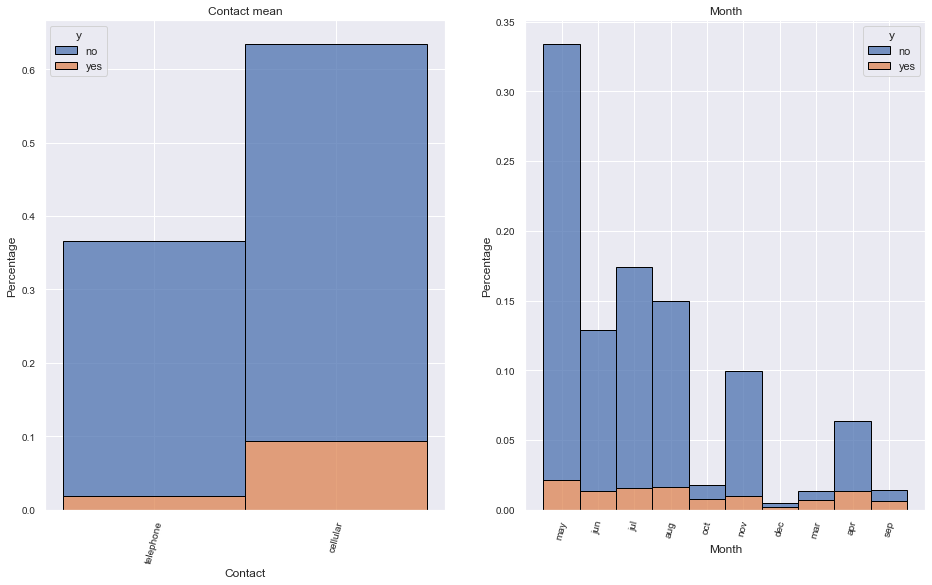

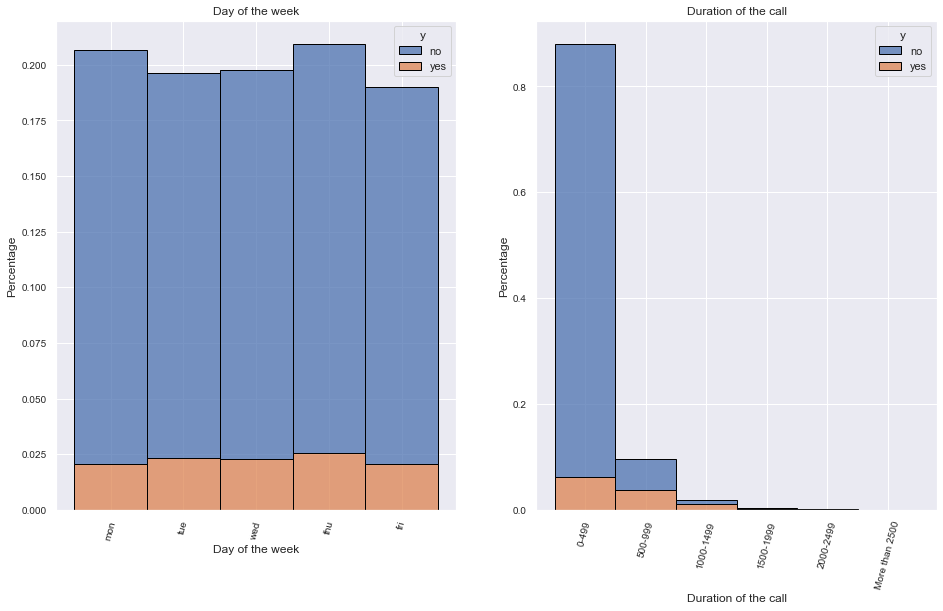

In [128]:
plt.figure(figsize=(33,9))

plt.subplot(1,4,1)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=contact_df, x='contact', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Contact") 
plt.ylabel("Percentage")
plt.title("Contact mean")

plt.subplot(1,4,2)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=contact_df, x='month', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Month") 
plt.ylabel("Percentage")
plt.title("Month")

plt.figure(figsize=(33,9))

plt.subplot(1,4,3)

#fig, ax = plt.subplots(figsize = (9, 5))
#plt.setp( ax.get_xticklabels(),rotation=90)
ax = sns.histplot(data=contact_df, x='day_of_week', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Day of the week") 
plt.ylabel("Percentage")
plt.title("Day of the week")

plt.subplot(1,4,4)

#fig, ax = plt.subplots(figsize = (9, 5))
#plt.setp( ax.get_xticklabels(),rotation=90)
ax = sns.histplot(data=contact_df, x='duration_range', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Duration of the call") 
plt.ylabel("Percentage")
plt.title("Duration of the call")


### Contact medium and target

In [61]:
cross_tab_contact = pd.crosstab(contact_df['y'],contact_df["contact"]).apply(lambda x: x/x.sum() * 100)
cross_tab_contact = cross_tab_contact.transpose()
print("Contact and target: ")
cross_tab_contact

Contact and target: 


y,no,yes
contact,,
cellular,85.262393,14.737607
telephone,94.768679,5.231321


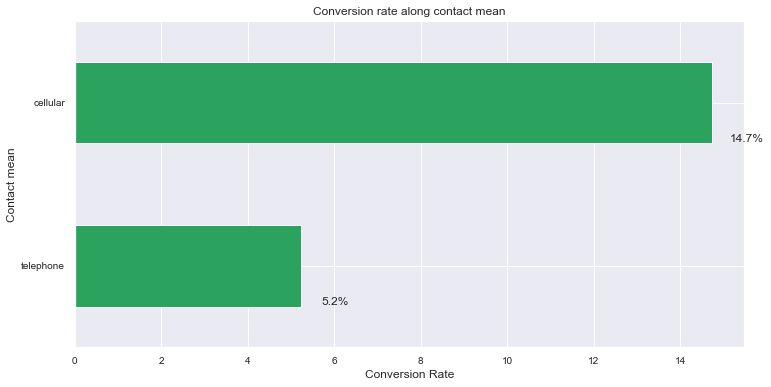

In [62]:
contact = cross_tab_contact['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along contact mean')
plt.xlabel('Conversion Rate')
plt.ylabel('Contact mean')

# Por estas funciones prefiero ggplot
for rec, label in zip(contact.patches,
                      cross_tab_contact["yes"].sort_values(ascending = True).round(1).astype(str)):
    contact.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

The acceptance rate through cellular is way higher than telephone.

### Month and target

In [65]:
cross_tab_month = pd.crosstab(contact_df['y'],contact_df["month"]).apply(lambda x: x/x.sum() * 100)
cross_tab_month = cross_tab_month.transpose()
print("Months and target: ")
cross_tab_month

Months and target: 


y,no,yes
month,,
apr,79.521277,20.478723
aug,89.397863,10.602137
dec,51.098901,48.901099
jul,90.953443,9.046557
jun,89.488530,10.511470
mar,49.450549,50.549451
may,93.565255,6.434745
nov,89.856133,10.143867
oct,56.128134,43.871866


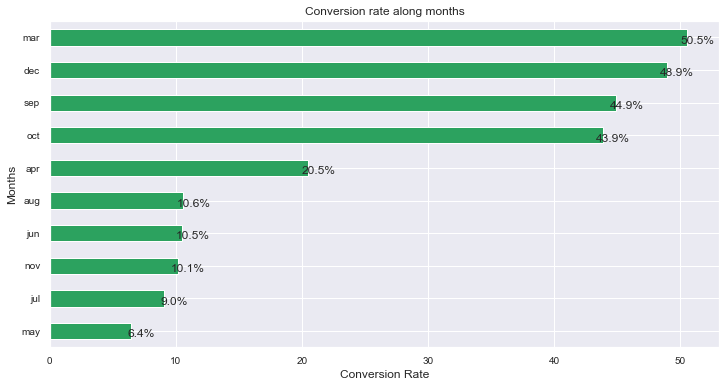

In [64]:
month = cross_tab_month['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along months')
plt.xlabel('Conversion Rate')
plt.ylabel('Months')

# Por estas funciones prefiero ggplot
for rec, label in zip(month.patches,
                      cross_tab_month["yes"].sort_values(ascending = True).round(1).astype(str)):
    month.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')


March, december, september and october are months with an acceptance rate of over 40%.

### Day of the week and target

In [67]:
cross_tab_day = pd.crosstab(contact_df['y'],contact_df["day_of_week"]).apply(lambda x: x/x.sum() * 100)
cross_tab_day = cross_tab_day.transpose()
print("Days and target: ")
cross_tab_day

Days and target: 


y,no,yes
day_of_week,,
fri,89.191261,10.808739
mon,90.051680,9.948320
thu,87.881248,12.118752
tue,88.220025,11.779975
wed,88.332924,11.667076


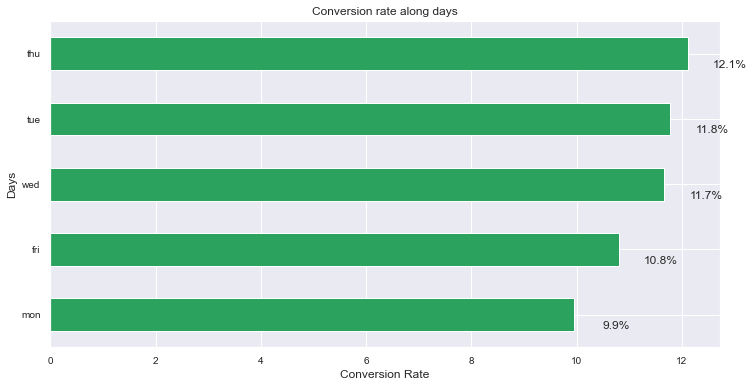

In [68]:
days = cross_tab_day['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along days')
plt.xlabel('Conversion Rate')
plt.ylabel('Days')

# Por estas funciones prefiero ggplot
for rec, label in zip(days.patches,
                      cross_tab_day["yes"].sort_values(ascending = True).round(1).astype(str)):
    days.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')



The acceptance rate through the days is similar.

### Duration and target

In [70]:
ranges=[-1,300,600,900,1200,1500,1800,2100,2400,5000]
labels=["0-300","301-600","601-900","901-1200","1201-1500","1501-1800","1801-2100","2101-2400","More than 2400"]

contact_df["duration_range"]=pd.cut(contact_df.duration,bins= ranges,labels=labels)



In [71]:
cross_tab_duration = pd.crosstab(contact_df['y'],contact_df["duration_range"]).apply(lambda x: x/x.sum() * 100)
cross_tab_duration = cross_tab_duration.transpose()
print("Duration range and target: ")
cross_tab_duration

Duration range and target: 


y,no,yes
duration_range,,
0-300,94.937300,5.062700
301-600,81.421189,18.578811
601-900,57.672927,42.327073
901-1200,42.838542,57.161458
1201-1500,37.459283,62.540717
1501-1800,34.285714,65.714286
1801-2100,39.285714,60.714286
2101-2400,42.857143,57.142857
More than 2400,41.935484,58.064516


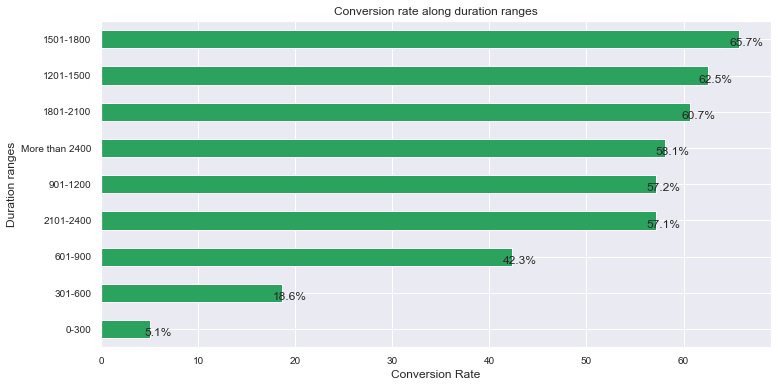

In [72]:
duration = cross_tab_duration['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along duration ranges')
plt.xlabel('Conversion Rate')
plt.ylabel('Duration ranges')

# Por estas funciones prefiero ggplot
for rec, label in zip(duration.patches,
                      cross_tab_duration["yes"].sort_values(ascending = True).round(1).astype(str)):
    duration.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Despite the fact that long calls, seems to be a synonim of better conversion, the real situation shows that there are very few calls that last more than 1500 seconds. The focus should be in the first 5 ranges.

### Campaign and target

Text(0.5, 1.0, 'Outcome from previous campaign')

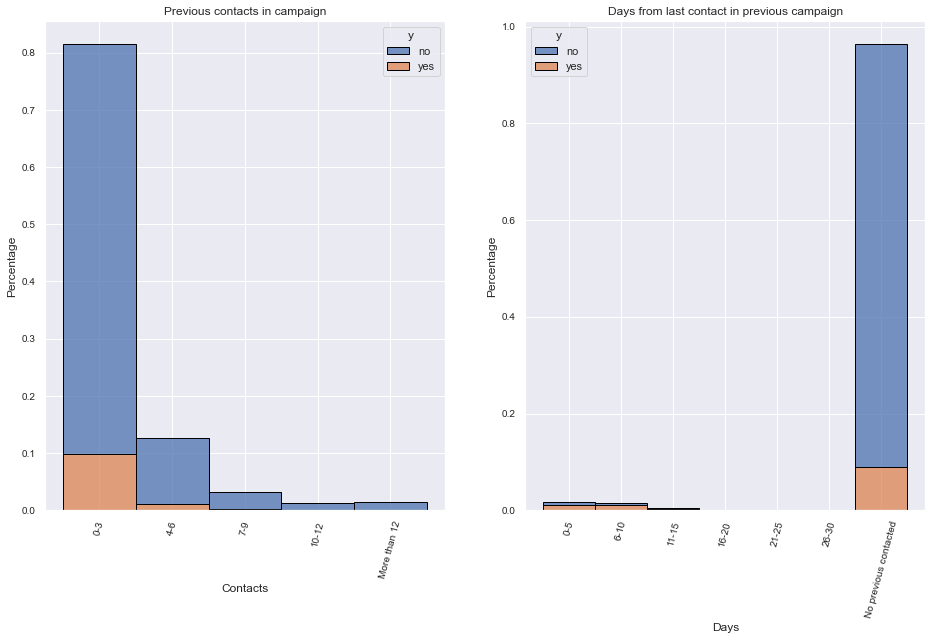

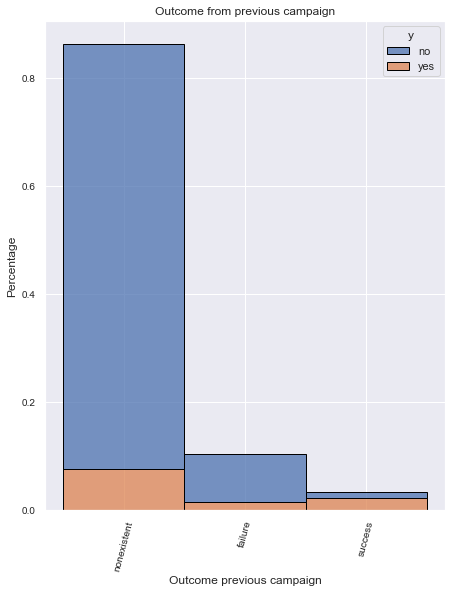

In [79]:
plt.figure(figsize=(33,9))

plt.subplot(1,4,1)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=campaign_df, x='campaign_range', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Contacts") 
plt.ylabel("Percentage")
plt.title("Previous contacts in campaign")

plt.subplot(1,4,2)

#fig, ax = plt.subplots(figsize = (9, 5))
ax = sns.histplot(data=campaign_df, x='pdays_range', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Days") 
plt.ylabel("Percentage")
plt.title("Days from last contact in previous campaign")

plt.figure(figsize=(33,9))

plt.subplot(1,4,3)

#fig, ax = plt.subplots(figsize = (9, 5))
#plt.setp( ax.get_xticklabels(),rotation=90)
ax = sns.histplot(data=campaign_df, x='poutcome', hue='y', binwidth=10,multiple='stack',stat="probability", edgecolor ='black')
plt.setp( ax.get_xticklabels(),rotation=75)
plt.xlabel("Outcome previous campaign") 
plt.ylabel("Percentage")
plt.title("Outcome from previous campaign")






In [73]:
cross_tab_campaign = pd.crosstab(contact_df['y'],campaign_df["campaign_range"]).apply(lambda x: x/x.sum() * 100)
cross_tab_campaign = cross_tab_campaign.transpose()
print("Campaign range and target: ")
cross_tab_campaign

Campaign range and target: 


y,no,yes
campaign_range,,
0-3,87.825232,12.174768
4-6,91.508893,8.491107
7-9,94.512195,5.487805
10-12,94.876660,5.123340
More than 12,97.883598,2.116402


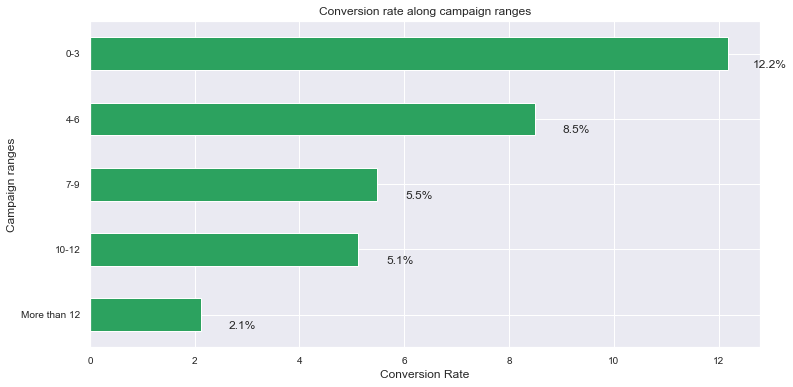

In [74]:
campaign = cross_tab_campaign['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along campaign ranges')
plt.xlabel('Conversion Rate')
plt.ylabel('Campaign ranges')

# Por estas funciones prefiero ggplot
for rec, label in zip(campaign.patches,
                      cross_tab_campaign["yes"].sort_values(ascending = True).round(1).astype(str)):
    campaign.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Seems to be that customers with better acceptance or conversion rate are customers contacted 0-3 times. Consider that there are near 70% of customers, so take it into account for posterior analysis.

In [88]:
cross_tab_pdays = pd.crosstab(contact_df['y'],campaign_df["pdays_range"]).apply(lambda x: x/x.sum() * 100)
cross_tab_pdays = cross_tab_pdays.transpose()
print("Days from last contact in previous campaign and target: ")
cross_tab_pdays

Days from last contact in previous campaign and target: 


y,no,yes
pdays_range,,
0-5,36.879433,63.120567
6-10,33.003300,66.996700
11-15,42.168675,57.831325
16-20,56.666667,43.333333
21-25,16.666667,83.333333
26-30,0.000000,100.000000
No previous contacted,90.741814,9.258186


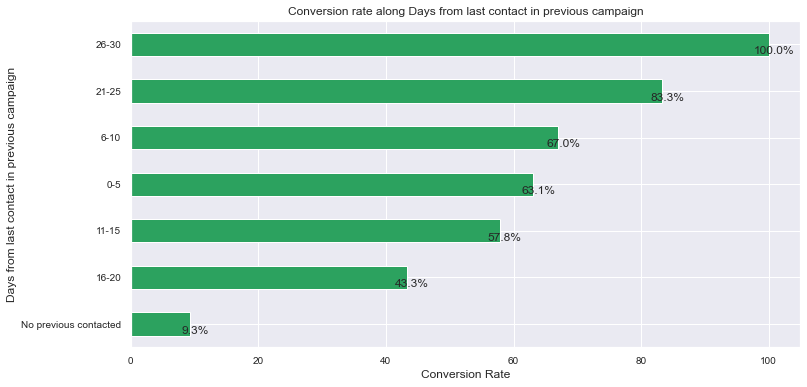

In [90]:
pdays = cross_tab_pdays['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate along Days from last contact in previous campaign')
plt.xlabel('Conversion Rate')
plt.ylabel('Days from last contact in previous campaign')

# Por estas funciones prefiero ggplot
for rec, label in zip(pdays.patches,
                      cross_tab_pdays["yes"].sort_values(ascending = True).round(1).astype(str)):
    pdays.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

In [84]:
campaign_df.pdays_range.value_counts()

No previous contacted    39673
0-5                        705
6-10                       606
11-15                      166
16-20                       30
21-25                        6
26-30                        2
Name: pdays_range, dtype: int64

In [85]:
39673/41188

0.9632174419733903

Most of customers were not contacted before, 96%.

In [86]:
cross_tab_previous = pd.crosstab(contact_df['y'],campaign_df["previous"]).apply(lambda x: x/x.sum() * 100)
cross_tab_previous = cross_tab_previous.transpose()
print("Contacts before this campaign and target: ")
cross_tab_previous

Contacts before this campaign and target: 


y,no,yes
previous,,
0,91.167787,8.832213
1,78.798509,21.201491
2,53.580902,46.419098
3,40.740741,59.259259
4,45.714286,54.285714
5,27.777778,72.222222
6,40.000000,60.000000
7,100.000000,0.000000


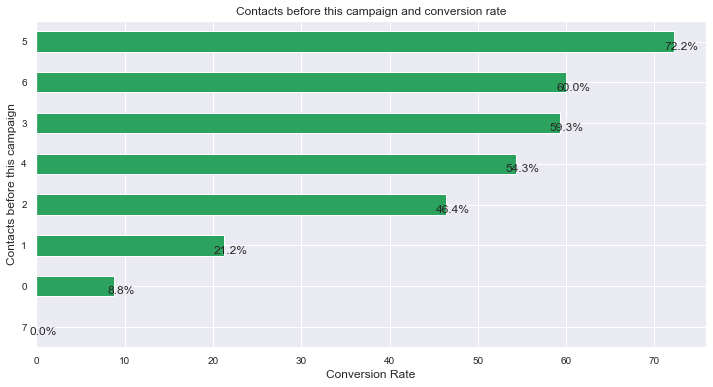

In [91]:
previous = cross_tab_previous['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Contacts before this campaign and conversion rate')
plt.xlabel('Conversion Rate')
plt.ylabel('Contacts before this campaign')

# Por estas funciones prefiero ggplot
for rec, label in zip(previous.patches,
                      cross_tab_previous["yes"].sort_values(ascending = True).round(1).astype(str)):
    previous.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

More contacts seems to be better acceptance/conversion rate.

In [92]:
cross_tab_poutcome = pd.crosstab(contact_df['y'],campaign_df["poutcome"]).apply(lambda x: x/x.sum() * 100)
cross_tab_poutcome = cross_tab_poutcome.transpose()
print("Outcome from previous campaign and target: ")
cross_tab_poutcome

Outcome from previous campaign and target: 


y,no,yes
poutcome,,
failure,85.771402,14.228598
nonexistent,91.167787,8.832213
success,34.887109,65.112891


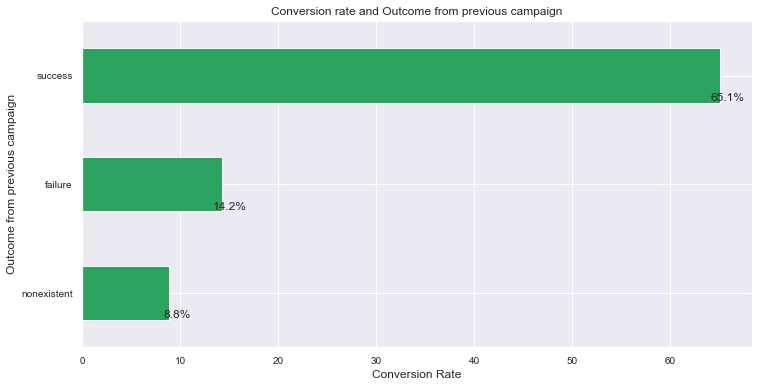

In [93]:
poutcome = cross_tab_poutcome['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Conversion rate and Outcome from previous campaign')
plt.xlabel('Conversion Rate')
plt.ylabel('Outcome from previous campaign')

# Por estas funciones prefiero ggplot
for rec, label in zip(poutcome.patches,
                      cross_tab_poutcome["yes"].sort_values(ascending = True).round(1).astype(str)):
    poutcome.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Customers with a success in previous campaign have a way higher acceptance rate now.

### Socioeconomic features and target

In [99]:
socioeconomic_df.describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,1.570960,0.578840,4.628198,1.734447,72.251528
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [105]:
paleta = ["#fc8d59","#3288bd"]
yes_df = socioeconomic_df[socioeconomic_df['y'] == "yes"]
no_df = socioeconomic_df[socioeconomic_df['y'] == "no"]

### Employment variation rate and target

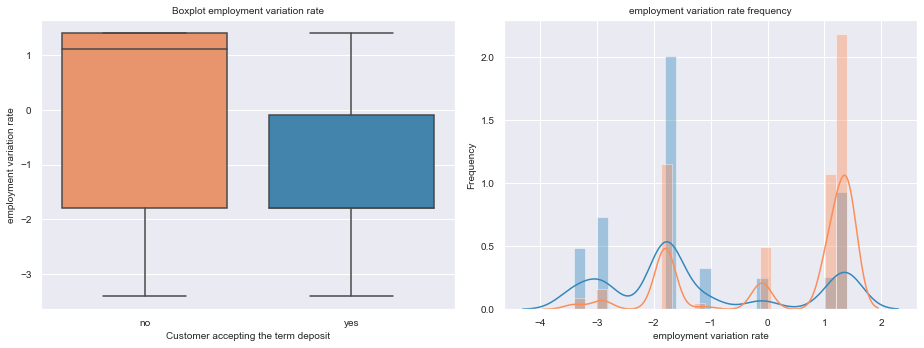

In [115]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='emp.var.rate', x='y', data=socioeconomic_df, palette=paleta, ax = ax1)
ax1.set_xlabel('Customer accepting the term deposit', fontsize=10)
ax1.set_ylabel('employment variation rate', fontsize=10)
ax1.set_title('Boxplot employment variation rate', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['emp.var.rate'],color='#3288bd', ax = ax2)
sns.distplot(no_df['emp.var.rate'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('employment variation rate', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('employment variation rate frequency', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

### Consumer price index and target

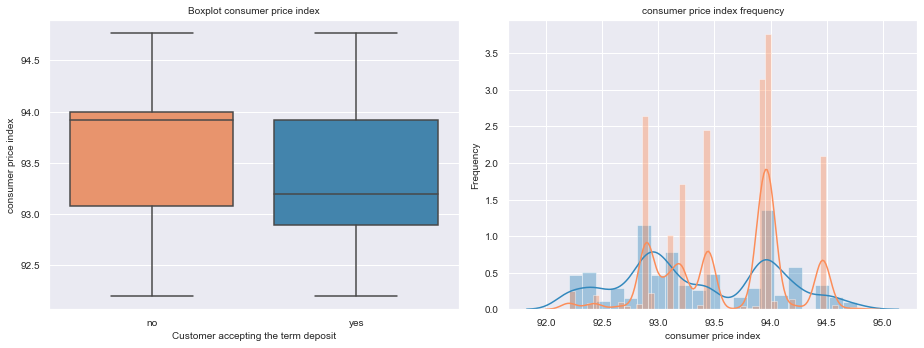

In [114]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='cons.price.idx', x='y', data=socioeconomic_df, palette=paleta, ax = ax1)
ax1.set_xlabel('Customer accepting the term deposit', fontsize=10)
ax1.set_ylabel('consumer price index', fontsize=10)
ax1.set_title('Boxplot consumer price index', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['cons.price.idx'],color='#3288bd', ax = ax2)
sns.distplot(no_df['cons.price.idx'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('consumer price index', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('consumer price index frequency', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

### Consumer confidence index and target

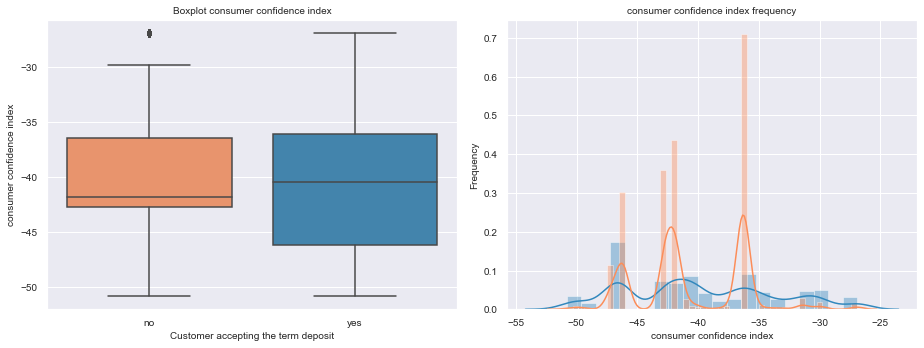

In [116]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='cons.conf.idx', x='y', data=socioeconomic_df, palette=paleta, ax = ax1)
ax1.set_xlabel('Customer accepting the term deposit', fontsize=10)
ax1.set_ylabel('consumer confidence index', fontsize=10)
ax1.set_title('Boxplot consumer confidence index', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['cons.conf.idx'],color='#3288bd', ax = ax2)
sns.distplot(no_df['cons.conf.idx'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('consumer confidence index', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('consumer confidence index frequency', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

### Euribor 3 month rate and target

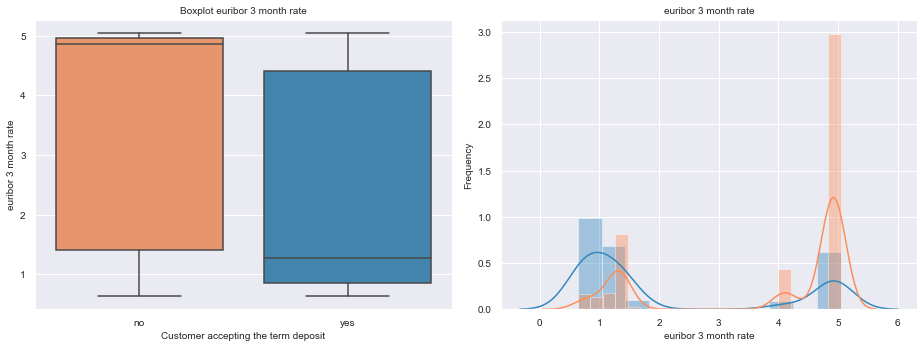

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='euribor3m', x='y', data=socioeconomic_df, palette=paleta, ax = ax1)
ax1.set_xlabel('Customer accepting the term deposit', fontsize=10)
ax1.set_ylabel('euribor 3 month rate', fontsize=10)
ax1.set_title('Boxplot euribor 3 month rate', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['euribor3m'],color='#3288bd', ax = ax2)
sns.distplot(no_df['euribor3m'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('euribor 3 month rate', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('euribor 3 month rate', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

### Number of employees and target

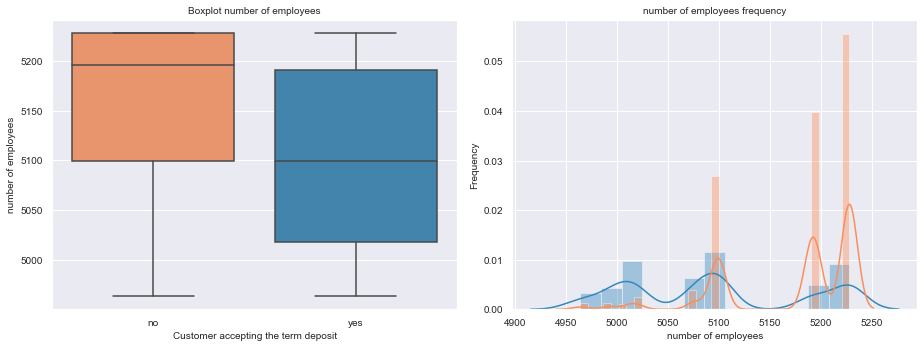

In [122]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='nr.employed', x='y', data=socioeconomic_df, palette=paleta, ax = ax1)
ax1.set_xlabel('Customer accepting the term deposit', fontsize=10)
ax1.set_ylabel('number of employees', fontsize=10)
ax1.set_title('Boxplot number of employees', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['nr.employed'],color='#3288bd', ax = ax2)
sns.distplot(no_df['nr.employed'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('number of employees', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('number of employees frequency', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

# III) Outliers

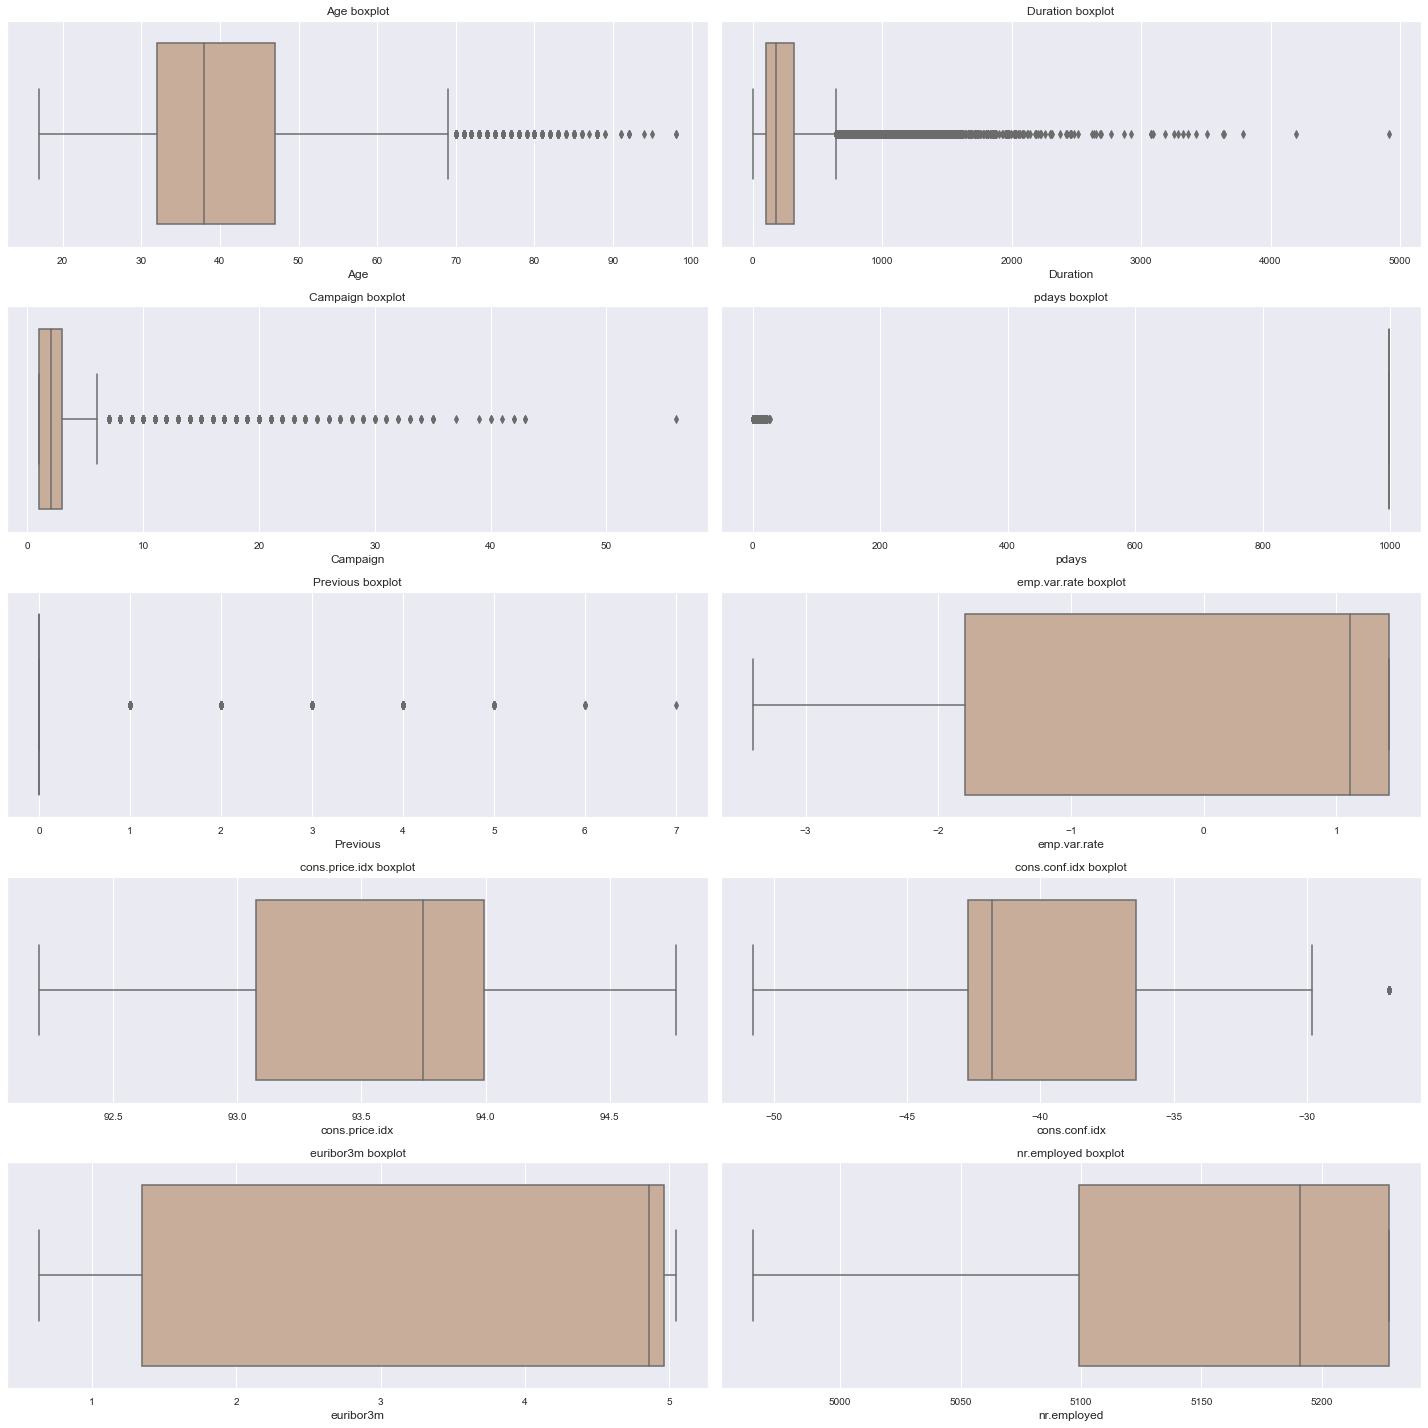

In [124]:
plt.figure(figsize = (20,20))
plt.subplot(5, 2, 1)
sns.boxplot(data = df, x= 'age', palette = 'pink')
plt.title('Age boxplot')
plt.xlabel('Age')

plt.subplot(5, 2, 2)
sns.boxplot(data = df, x= 'duration', palette = 'pink')
plt.title('Duration boxplot')
plt.xlabel('Duration')

plt.subplot(5, 2, 3)
sns.boxplot(data = df, x= 'campaign', palette = 'pink')
plt.title('Campaign boxplot')
plt.xlabel('Campaign')

plt.subplot(5, 2, 4)
sns.boxplot(data = df, x= 'pdays', palette = 'pink')
plt.title('pdays boxplot')
plt.xlabel('pdays')

plt.subplot(5, 2, 5)
sns.boxplot(data = df, x= 'previous', palette = 'pink')
plt.title('Previous boxplot')
plt.xlabel('Previous')

plt.subplot(5, 2, 6)
sns.boxplot(data = df, x= 'emp.var.rate', palette = 'pink')
plt.title('emp.var.rate boxplot')
plt.xlabel('emp.var.rate')

plt.subplot(5, 2, 7)
sns.boxplot(data = df, x= 'cons.price.idx', palette = 'pink')
plt.title('cons.price.idx boxplot')
plt.xlabel('cons.price.idx')

plt.subplot(5, 2, 8)
sns.boxplot(data = df, x= 'cons.conf.idx', palette = 'pink')
plt.title('cons.conf.idx boxplot')
plt.xlabel('cons.conf.idx')

plt.subplot(5, 2, 9)
sns.boxplot(data = df, x= 'euribor3m', palette = 'pink')
plt.title('euribor3m boxplot')
plt.xlabel('euribor3m')

plt.subplot(5, 2, 10)
sns.boxplot(data = df, x= 'nr.employed', palette = 'pink')
plt.title('nr.employed boxplot')
plt.xlabel('nr.employed')

plt.tight_layout()
plt.show()

Based on the boxplots (IQR), we can think that variables needing outliers treatment are:

- Age

- Duration

- Campaign

As the asignment statement says, "duration" highly affects the output target, so we are going to put it aside for the rest of the analysis. It is useless to work in it if we are dropping it later.

As we have talked in week 9, we are working with two criteria for outliers: IQR and WOE. In model weeks, we are going to analyse which is better treatment. 

# IV) Missing values

As we defined in week 9 too, the first criteria adopted is to drop missing values ("unknown"), to avoid bias.

We are now considering a new option, that is to consider "unknown" as a whole category to keep the information of not unknowns.

